<a href="https://colab.research.google.com/github/clarkdatalabs/bibliometric_networks/blob/master/JordanNEW_SCOPUS_data_manip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliographic Networks: A Python Tutorial

Networks can provide significant measures to identify data driven patterns and dependencies. Though, given a data file it can be difficult to discern how one may approach creating such a network. In this tutorial, we will use a bibliographic data file downloaded from a query search in <a href = https://www.scopus.com/search/form.uri>Scopus</a> to walk through the process of cleaning the data file, writing a python script to parse the data into nodes and edges, computing graphical measures using <a href = https://networkx.github.io/documentation/stable/index.html>NetworkX</a>, and creating an interactive network display using <a hred = http://holoviews.org/>HoloViews</a>. 

### Notes on Data Manipulation in Excel

As you are editing and cleaning your data set, be sure to always save in Excel as <i>CSV UTF-8 (Comma delimited) (.csv)</i>. This will ensure that the data file is readable by the python reader and contains original special characters. 

This rest of this section is specific to SCOPUS downloaded files, as some downloadable queries are unfortunately imperfect. Firstly, some rows are skewed from inaccurate reading and parsing. Simply scroll through the file and delete any rows where the data is clearly mismatched (i.e. an author name in the 'Title' column, a numerical value in a non-numerical column, etc.). 

Additionally, across several different queries, we discovered duplicates in entry 'Title,' with other columns containing conflicting data. To fix this issue for the purposes of producing a network, we want to remove duplicates. 

In Excel with your csv file open, select Date -> Table Tools -> Remove Duplicates. Indicate that the csv file has headers, as all SCOPUS files will, and only select the 'Title' column by which duplicates will be identified. 

After executing this command, it is important to save the file as a csv. Otherwise, Excel may default to a txt, or other format, and some data features may be lost. By continuously saving the file as a csv, we ensure that it will continue to be compatible with the python code for this tutorial.

Generally, for the case of creating a connected network, we want the rows in our bibliographic data file to have an identifiable title and list of references. 

### Import Necessary Libraries and Packages 
The following code will download the necessary libraries and packages for this tutorial. To successfully import, one must be sure that these libraries and installed locally on the computer. 

Using pip, the following libraries can be installed in the terminal window of your computer. 
- pip install networkx
- pip install numpy
- pip install pandas 
- pip install holoviews 
- pip install bokeh 
- pip install scikit-image
- pip install xarray
- pip install datashader

To customize this tutorial, decalare your own csv file. 

In [1]:
!pip install networkx
!pip install numpy
!pip install pandas
!pip install holoviews
!pip install bokeh
!pip install scikit-image
!pip install xarray
!pip install datashader

    100% |████████████████████████████████| 4.0MB 3.6MB/s 
    100% |████████████████████████████████| 71kB 21.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/45/8e/f1/231c7191fce4aed4f0e7276b0628d3561770879c65d90e3e97
Successfully built pyviz-comms
    100% |████████████████████████████████| 11.3MB 2.0MB/s 
    100% |████████████████████████████████| 1.4MB 14.8MB/s 
    100% |████████████████████████████████| 163kB 27.5MB/s 
    100% |████████████████████████████████| 81kB 24.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
  Stored in directory: /root/.cache/pip/wheels/de/2c/ce/f826a534269a531d0cca2c93caafc8c10aee0d636303a7484d
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built datashape partd locket
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.0.1.post2 which is incompatible.
  Found existing installation: testpath 0.4.2

In [0]:
import csv
import networkx as nx
import numpy as np
import pandas as pd
import holoviews as hv
from holoviews import opts 
from holoviews.operation.datashader import datashade, bundle_graph

file_name = 'scopus.csv' # TODO: insert filename

### Scopus and bibliometric specific: fixing the data file 

The downloaded Scopus file identifies a title for a source in each row. The column 'References' indicates a semicolon delimited list of references in MLA/APA format. To make this information useful, we must parse title names from each reference in the list. To understand the function below, look at the formating of the 'References' column in your Scopus file. 

In [0]:
node_list = []
edge_list = []

def comp_add(node_list, node2, title): 
    for node1 in node_list: 
        if node2 in node1[0] or node1[0] in node2: 
            node2 = node1[0]
            # FIX double index name 
            break 
    # if 'title' == true, then append node with title notation 
    if title == True: 
        node_list.append([node2,'t'])
    # if 'title' == false, then append node with reference notation 
    else: 
        node_list.append([node2,'r'])
    
#def remove_whitespace(ref): 
    #if ref[0] == " ": 
        #ref = ref[1:]

with open(file_name) as csv_file:
    reader = csv.DictReader(csv_file)
    for row in reader:
        # add node with unique identifier
        sink_node = row['Title']
        comp_add(node_list,sink_node, True)
        # add an edge for each source and its references
        refs = row['References'].split(';')
        if refs != '': 
            for ref in refs:
                if 'https://' not in ref and 'http://' not in ref and ref != " " and ref != "": 
                # only include journal-type references, and clean data for any formatting inconsistencies 
                    #remove_whitespace(ref)
                    comp_add(node_list, ref, False)
                    edge = [ref, sink_node] # 'ref' references 'sink_node'
                    edge_list.append(edge)


### Graph Manipulation 
Once you have created an <i>edge_list</i> variable, edges can be added to an NetworkX graph. Using NetworkX for this graph manipulation is intuitive and clean, requiring minimal lines of code.

In [0]:
G = nx.Graph() 
color_map = []

for node in node_list: 
    if node[1] == 't': 
        G.add_node(node[0]) 
        color_map.append('blue')
    else: 
        G.add_node(node[0]) 
        color_map.append('red')
G.add_edges_from(edge_list)

For a large graph, depending on the information in the graph, one may want to prune the graph to only contain nodes with a degree greater than 1. For this bibliometric data, we are primarily concerning with the connections between nodes, therefore a node with only one connection is of much less importance. Furthermore, by removing these less significant nodes, we can decrease the graph size significantly, creating a more easily understood graphical layout. Be careful to run this code only as many times as you wish to reduce the graph, else significant information may be lost, depending on the degree of interest in the information quantity.  

In [0]:
nodes_to_remove = []
for n in G.nodes(): 
    if G.degree(n) == 1: 
        nodes_to_remove.append(n)
G.remove_nodes_from(nodes_to_remove)

In [0]:
nodes_to_remove = []
for n in G.nodes(): 
    if G.degree(n) == 0: 
        nodes_to_remove.append(n)
G.remove_nodes_from(nodes_to_remove)

In [0]:
import os

In [0]:
os.environ['HV_DOC_HTML'] = 'true'


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
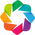

:Graph   [start,end]

In [16]:
hv.extension('bokeh')

# dimensions for graph window 
kwargs = dict(width=1000, height=1000, xaxis=None, yaxis=None)
opts.defaults(opts.Nodes(**kwargs), opts.Graph(**kwargs))

pos = nx.spring_layout(G,k=0.15,iterations=20)
my_graph = hv.Graph.from_networkx(G, pos, node_color = color_map)
bundled = bundle_graph(my_graph)
(datashade(bundled, normalization='linear', width=900, height=900) * bundled.nodes).opts(
    opts.Nodes(color='circle', size=10, width=1000, legend_position='right'))
datashade(bundle_graph(my_graph), normalization='linear', width=900, height=900)
bundled.opts(padding=0.1)

In [0]:
hv.show(my_graph)

AttributeError: ignored